#  CHE 614 course project final report: Heat transfer behavior modeling in core-shell paraffin@Silica nanoparticles with Openpnm.

## Main content: core-shell structure modeling, thermal conductance calculation, phase change expression, temperature distribution calculation, visualization and shell thickness effect on effective heat transfer coefficient.

## Jinhe Zhang #20985826

A core-shell structure material (paraffin@silica) model will be built in this project. This material contains solid silica shells, and pores structure which willl filled with paraffin.

## 1. Generating network
First build a core-shell structure model. Investigate heat transfer models within spatial networks. A cubic network will be built. Import the usual packages and instantiate a 3D cubic network for demonstration prupose:

In [1]:
import numpy as np
import openpnm as op
import scipy as sp
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
shape = [10, 10, 10]
spacing = 1e-5
net = op.network.Cubic(shape=shape, spacing=spacing)

------------------------------------------------------------
CRITICAL   : front and back labels have been switched to obey the right-hand rule 
SOURCE     : openpnm.network.Cubic.__init__ 
TIME STAMP : 2022-08-24 16:38:18,835
------------------------------------------------------------


## 2. Adding geometry
The paraffin-based core-shell phase change materials prepared in the existing literature tend to have oxide shell thicknesses of similar size and paraffin core diameters of different sizes(can be seen in the following figures). In my project, the diameter of the pores representing the core is set to be randomly distributed, and the thickness of the shell is set to a constant value. Use model from library to set wach throat diameter equals to its smallest neighbor pore.

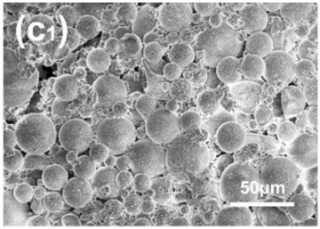
Energy, 2018, 158, 1052-1059

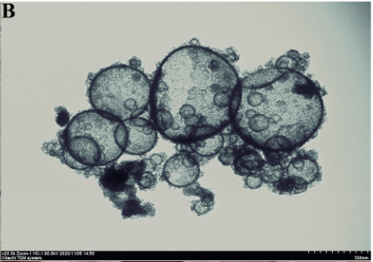
Colloids and Surfaces A: Physicochemical and Engineering Aspects 625 (2021) 126905!

In [3]:
geom = op.geometry.GenericGeometry(network=net, pores=net.Ps, throats=net.Ts)
geom['pore.diameter'] = np.random.rand(net.Np)*1e-5
mode = op.models.misc.from_neighbor_pores
geom['throat.diameter'] = mode(target=geom, prop='pore.diameter')

## 3. Adding phases
Assume that phases in the model mainly including paraffin core, silica shell and air pores. 
The heat transfer coefficients of paraffin before and after phase transition are different. So, the heat transfer coefficient in the phase 'prf' (means paraffin) will be further set according to the temperature in the Fourier conduction (in step 5). 
Moreover, considering this core-shell material is used at temperatures lower than the vaporization temperature of paraffin (~300°C). Based on this condition, it can further be assumed that the heat transfer coefficients of air and silica are constant values.

In [4]:
prf = op.phases.GenericPhase(network=net)
air = op.phases.Air(network=net)
Ka = air['pore.thermal_conductivity']   # air heat transfer coefficient
Kps = 0.4  #solid paraffin heat transfer coefficient
Kpl = 0.2  #liquid paraffin heat transfer coefficient
Ks = 0.27  #silica heat transfer coefficient

## 4. Adding physics
In the simulation of the core-shell structure, the paraffin component is treated as a sphere model, while the construction of the shell is calculated as part of the heat transfer into the throat model. 

In [5]:
phys = op.physics.GenericPhysics(network=net, phase=prf, geometry=geom)

The heat transfer process between the two core-shell nanospheres can be obtained by calculating the total thermal conductance. If the two spheres are touching each other, their heat transfer conductance can be regarded as consisting of two radii of paraffin and middle silica layer, a total of three parts. Another situation is that the two spheres are not in contact, so the heat transfer conductance between them can be regarded as two radii of paraffin, two silca shell layers and the air in the middle, a total of five parts (as shown in following figures).

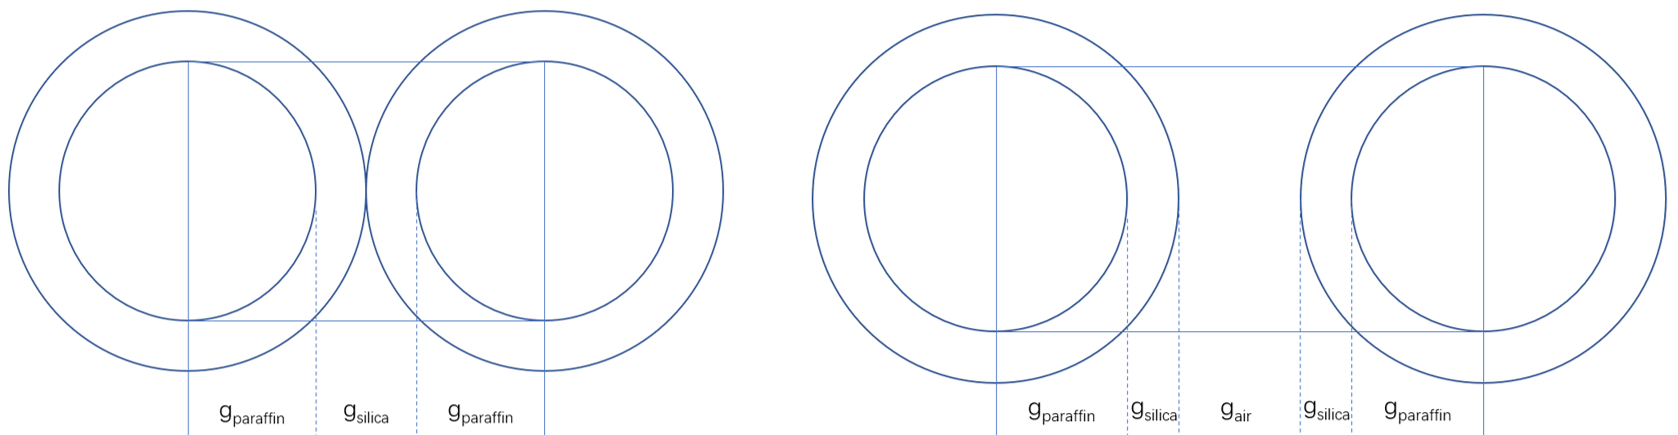

In [107]:
P12 = net['throat.conns']
D1 = geom['pore.diameter'][P12[:,0]]  # diameter of one pore/ paraffin core
D2 = geom['pore.diameter'][P12[:,1]]  # diameter of another pore/ paraffin core
R_T = geom['throat.diameter']/2  # radius of throat/ heat transfer channel
R_P = geom['pore.diameter']/2  # radius of pore/ paraffin core
R_w = spacing - D1/2 - D2/2  # the R_w means the distance between two paraffin sphere surfaces
Rs = 1.00E-06  # silica layer thickness

In [108]:
def gfunc(T, Kp):
        g_P = Kp*sp.pi*(R_P)**2/(R_P)
        g_th = np.zeros_like(R_T)              
        for i in range(len(R_w)):
            if R_w[i] - 2 * Rs > 0:  #means the air gap exist between two spheres
                R_sas = R_w - 2*Rs             
                g_T = np.mean(Ks)*sp.pi*(R_T[i])**2/(Rs)
                g_A = np.mean(Ka)*sp.pi*(R_T[i])**2/(R_sas[i])
                g_th[i] = (1/g_A + 2/g_T + 1/g_P[P12[i, 0]] + 1/g_P[P12[i, 1]])**-1
            else:   #means two spheres are connected
                g_T = np.mean(Ks)*sp.pi*(R_T[i])**2/(R_w[i])
                g_th[i] = (1/g_T + 1/g_P[P12[i, 0]] + 1/g_P[P12[i, 1]])**-1
        return g_th

Paraffin is a phase change material with different heat transfer coefficients in liquid and solid state. However, since the temperature distribution inside the grid is currently unknown, so the state of the paraffin cannot be determined. Therefore, it is necessary to obtain the preliminary temperature distribution in the grids. My method is: assuming that all the paraffin inside the material is in a solid state (the heat transfer coefficient is 0.4 W/mK), then calculate the temperature distribution.

In [109]:
phys['throat.thermal_conductance'] = gfunc(T=293.0, Kp=0.4)  #temporarily assuming all paraffin are in solid state

## 5. Performing fourier conduction
When we ignore the change of the heat transfer coefficient caused by the paraffin phase transition, we can obtain the temperature distribution through one time iterative operation by using this model. This situation often occurs when the inlet temperature and the outlet temperature are both higher or lower than the phase transition temperature. However, if the phase transition temperature is between the inlet temperature and the outlet temperature, the temperature distribution calculated after one iteration is inaccurate. The heat transfer coefficient of the paraffin at the temperature higher than the melting point should be corrected for the liquid phase. 

In [110]:
inlet = net.pores('left')  # set the inlet
outlet = net.pores('right')  # set the outlet
T_in = 333  # K, inlet temperature
T_out = 313  # K, outlet temperature
T_melting = 323  # K, paraffin melting temperature

In [111]:
fc = op.algorithms.FourierConduction(network=net)
fc.setup(phase=prf)
fc.set_value_BC(pores=inlet, values=T_in)
fc.set_value_BC(pores=outlet, values=T_out)
fc.run()

Now, the state of paraffin can be determined by the temperature distribution. The paraffin with temperature higher than 323K is regarded as liquid, and the temperature less than or equal to 323K is in solid state. However, this process may require multiple iterations to achieve relatively accurate results. At least 5 iterations are required for a structure with 1000 pores in this model. For models with more pores, more iterations are required.

In [112]:
num = 5  # times of iterate
for x in range(num):
    T_p = fc['pore.temperature']
    K_prf = np.zeros_like(R_P)
    for i in range(len(T_p)):
        if T_p[i] > T_melting:
            K_prf[i] = Kpl
        else:
            K_prf[i] = Kps
    prf['pore.thermal_conductivity'] = K_prf
    phys['throat.thermal_conductance'] = gfunc(T = T_p, Kp=K_prf)
    fc = op.algorithms.FourierConduction(network=net)
    fc.setup(phase=prf)
    fc.set_value_BC(pores=inlet, values=T_in)
    fc.set_value_BC(pores=outlet, values=T_out)
    fc.run()

A relatively correct paraffin state distribution is obtained, and the above calculation process is repeated to obtain a modified temperature distribution. Now, we have a much more reliable temperature distribution. And this process, this model can be directly applied to various temperature ranges below the paraffin gasification temperature.

## 6.Calculate the effective heat transfer coefficient.
Calculate Effective Thermal Conductivity Using Fourier's Law.

$$k_{eff}=\frac{q \cdot A}{L \cdot \Delta T} $$

In [113]:
rate_inlet = fc.rate(pores=inlet)[0]
A = (shape[0] * shape[1])*(spacing**2)
L = shape[2]*spacing
k_eff = rate_inlet * L / (A * (T_in - T_out))
print("{0:.6E}".format(k_eff))

1.798345E-02


## 7. Visualization
Drawing with matplotlib

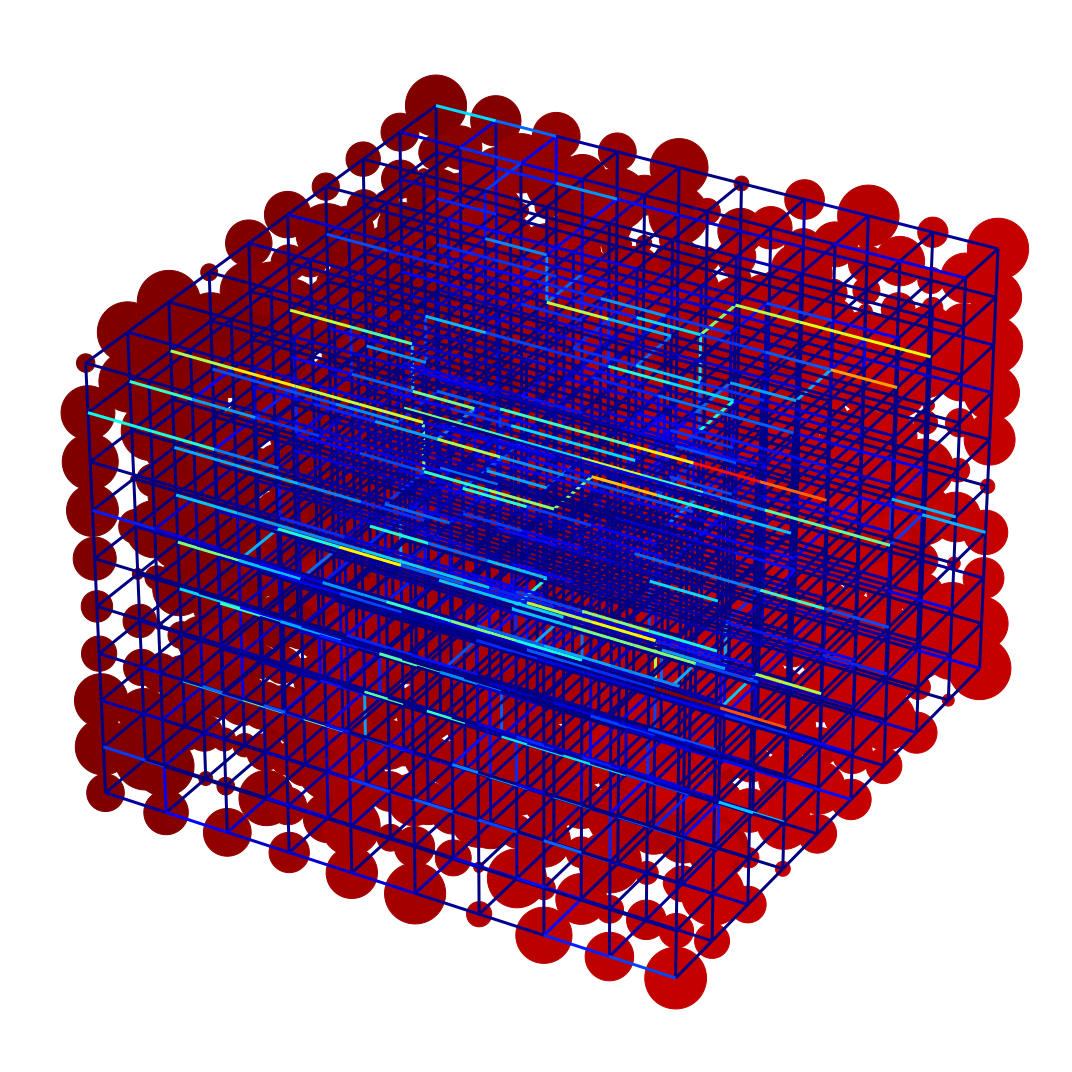

In [13]:
t = fc['pore.temperature']
r = fc.rate(throats=net.Ts, mode='single')
d = net['pore.diameter']
fig, ax = plt.subplots(figsize=[30,15])
op.topotools.plot_coordinates(network=net, color_by=t, size_by=d, markersize=4000, ax=ax)
op.topotools.plot_connections(network=net, color_by=r, linewidth=3, ax=ax)
_ = plt.axis('off')

(array([126.,  83.,  80., 102., 137.,  94.,  80.,  75.,  88., 135.]),
 array([313., 315., 317., 319., 321., 323., 325., 327., 329., 331., 333.]),
 <BarContainer object of 10 artists>)

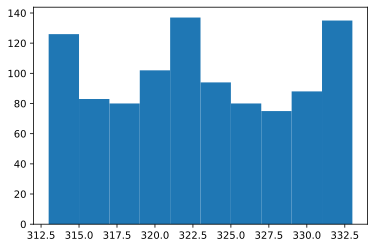

In [14]:
plt.hist(fc['pore.temperature'])

Or use paraview for visualization

In [16]:
net.project.export_data(phases=[fc], filename='60to40_ls_prf', filetype='vtk')

------------------------------------------------------------
SOURCE     : openpnm.io.VTK.export_data 
TIME STAMP : 2022-08-24 16:44:14,527
------------------------------------------------------------
------------------------------------------------------------
SOURCE     : openpnm.io.VTK.export_data 
TIME STAMP : 2022-08-24 16:44:14,528
------------------------------------------------------------


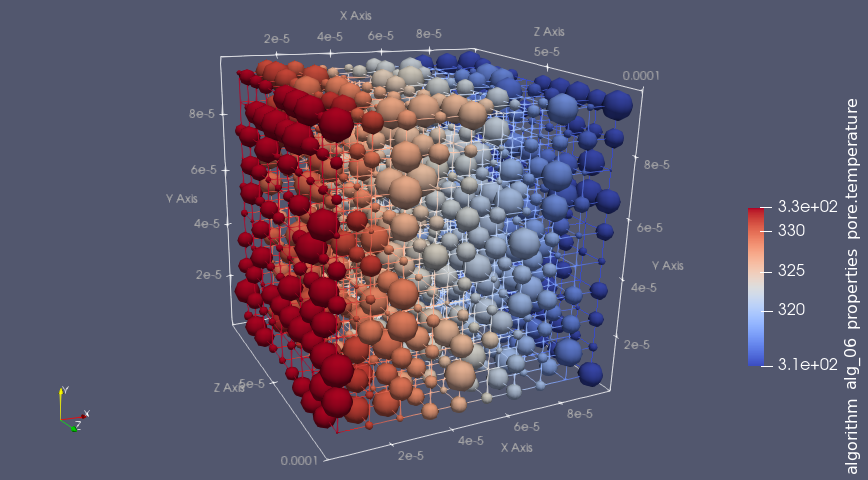

Usually, the phase change temperature of paraffin is a temperature range, which can be determined experimentally (in this project, we can assume the range is 321K~325K). According to the above temperature distribution, paraview can be used to further define the state of paraffin. As shown in the figure below, dark red represents liquid paraffin, dark blue represents solid paraffin, and the light-colored part in the middle can be defined as the phase change layer or phase boundary.

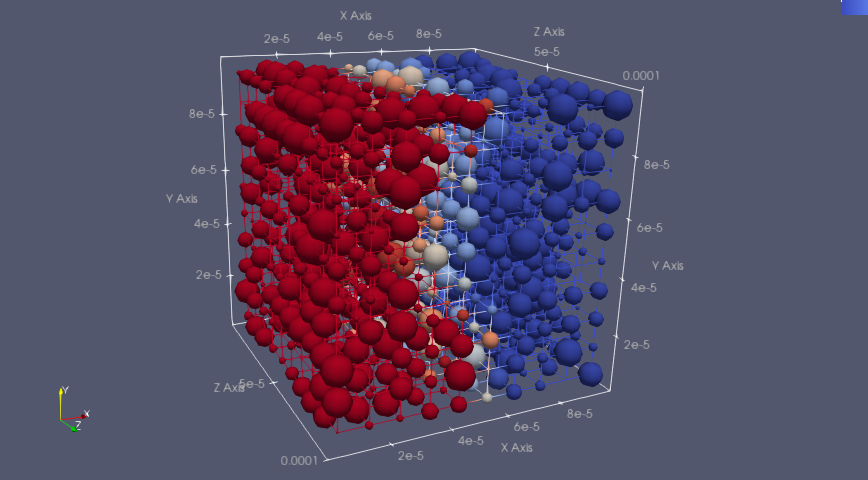

## 8. Shell thickness effect on K_eff
Paraffin has high low heat transfer coefficient. One of the effective ways to increase the effective heat transfer coefficient of a material is to coat paraffin with an oxide shell. The model established above can also study the effect of shell thickness on the effective heat transfer coefficient. It can be seen from the results that the thickness of the shell layer increases, and the effective heat transfer coefficient of the material also increases. Moreover, the effect of shell thickness on the effective heat transfer coefficient in different temperature intervals are calculated and compared.

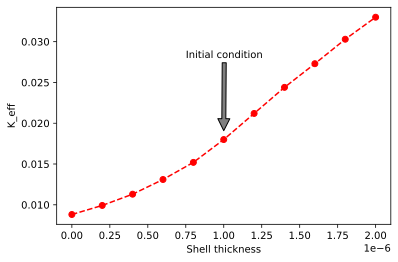

In [3]:
x=[0.00E+00, 2.00E-07,4.00E-07,6.00E-07,8.00E-07,1.00E-06,1.20E-06,1.40E-06,1.60E-06,1.80E-06,2.00E-06]
y=[8.81E-03,9.92E-03,1.13E-02,1.31E-02,1.52E-02,1.80E-02,2.12E-02,2.44E-02,2.73E-02,3.03E-02,3.30E-02]
plt.plot(x,y,color='r',marker='o',linestyle='dashed')
plt.xlabel('Shell thickness')
plt.ylabel('K_eff')
plt.annotate('Initial condition', xy=(1.00E-06,1.90E-02), xytext=(0.75E-06, 2.80E-02),
            arrowprops=dict(facecolor='grey', shrink=0.01),
            )
plt.show()

By using this model, the inlet outlet temperature was further modified, and the effect of shell thickness on the effective heat transfer coefficient was studied. Since the pores sizes are randomly generated, the result of the calculation may be different each time the entire program is rerun. However, the law of change is objective.

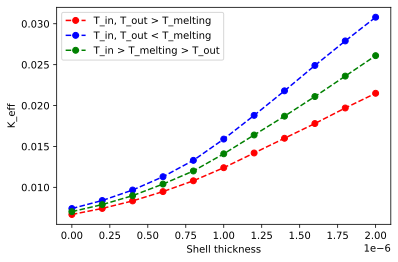

In [4]:
#  The following three sets of data are calculated by the same model. 
x=[0.00E+00, 2.00E-07,4.00E-07,6.00E-07,8.00E-07,1.00E-06,1.20E-06,1.40E-06,1.60E-06,1.80E-06,2.00E-06]
y1=[6.68E-03, 7.42E-03, 8.34E-03, 9.48E-03, 1.08E-02, 1.24E-02, 1.42E-02, 1.60E-02, 1.78E-02, 1.97E-02, 2.15E-02]
y2=[7.41E-03, 8.39E-03, 9.67E-03, 1.13E-02, 1.33E-02, 1.59E-02, 1.88E-02, 2.18E-02, 2.49E-02, 2.79E-02, 3.08E-02]
y3=[7.03E-03, 7.89E-03, 8.98E-03, 1.04E-02, 1.20E-02, 1.41E-02, 1.64E-02, 1.87E-02, 2.11E-02, 2.36E-02, 2.61E-02]
plt.plot(x,y1,color='red',marker='o',linestyle='dashed', label="T_in, T_out > T_melting")
plt.plot(x,y2,color='blue',marker='o',linestyle='dashed', label="T_in, T_out < T_melting")
plt.plot(x,y3,color='green',marker='o',linestyle='dashed', label="T_in > T_melting > T_out")
plt.xlabel('Shell thickness')
plt.ylabel('K_eff')
plt.legend(loc="best", fontsize=10)
plt.show()

## 9. Conclusion and deficiencies

In this project, the heat transfer model of the core-shell structure is first constructed using the calculation representation of the heat transfer coefficient. Furthermore, the effect of paraffin phase transition on the heat transfer coefficient was considered through iterative calculation. According to the given boundary conditions, the model can give a relatively reasonable temperature distribution and calculate the effective thermal conductivity of the material regardless of whether there is a paraffin phase transition. Moreover, through the visualization of the temperature distribution, the phase transition boundary can be found. Simulations of heat transfer behavior with different shell thicknesses show that the effective heat transfer coefficient increases with increasing shell thickness.

In this project, the judgment of phase transition is defined based on temperature distribution. However, the phase transition of paraffin is a more complex process. Based on my future experiments, I hope to develope the simulation of the paraffin phase change process closer to real situation. For example, I hope to be able to add time variables to the model to achieve a more realistic simulation of the phase transition and to consider the latent heat effect on heat transfer behavior. 